In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()
# engine.execute('SELECT * FROM station LIMIT 5').fetchall()
# meas_cols = session.query(measurement).first()
# meas_cols.__dict__
stat_cols = session.query(station).first()
stat_cols.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2482161d088>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

# Exploratory Climate Analysis

2017-08-23, 2016-08-23 00:00:00


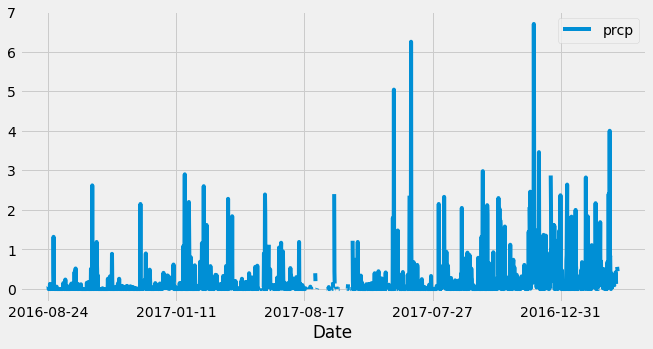

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
session.query(measurement.date).order_by(measurement.date.desc())
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date = latest_date[0]
year_ago = dt.datetime.strptime(latest_date, "%Y-%m-%d")- dt.timedelta(days=365)

print(f'{latest_date}, {year_ago}')
# Perform a query to retrieve the data and precipitation scores
yr_prcp=engine.execute("SELECT date, prcp FROM measurement WHERE date > '2016-08-23'").fetchall()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(yr_prcp, columns =['Date', 'prcp'])
# prcp_df.head(10)
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
data_plot = prcp_df.plot(x='Date', y='prcp', rot=0, figsize=(10, 5))
data_plot

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
engine.execute('SELECT DISTINCT station, name FROM station').fetchall()

[('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_df=pd.DataFrame(engine.execute('SELECT station, COUNT( station ) AS "Num_of_rows" '
               'FROM measurement GROUP BY station '
               'ORDER BY Num_of_rows DESC').fetchall())
station_df

,0,1
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
Max=engine.execute("SELECT MAX(tobs) FROM measurement WHERE station = 'USC00519281'").fetchall()
Min=engine.execute("SELECT MIN(tobs) FROM measurement WHERE station = 'USC00519281'").fetchall()
avg=engine.execute("SELECT ROUND(AVG(tobs), 2) FROM measurement WHERE station = 'USC00519281'").fetchall()
print(f'Waihee station previous year - \n\
Maximum temperatrue: {Max}, \n\
Minimum temperatrue: {Min}, \n\
Average temperatrue: {avg}')

Waihee station previous year - 
Maximum temperatrue: [(85.0,)], 
Minimum temperatrue: [(54.0,)], 
Average temperatrue: [(71.66,)]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024822EC72C8>]],
      dtype=object)

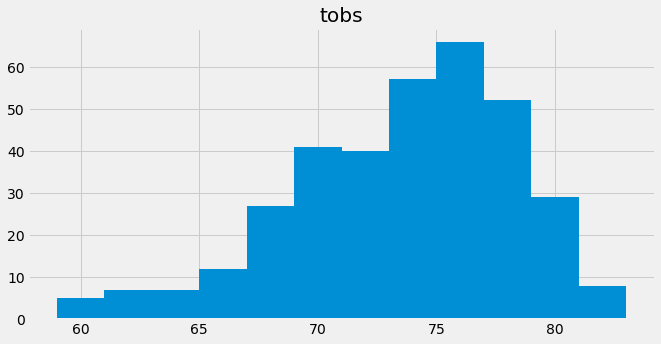

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
waihee_tobs=engine.execute("SELECT date, tobs FROM measurement \n\
WHERE date > '2016-08-23' AND station = 'USC00519281'").fetchall()
waihee_df=pd.DataFrame(waihee_tobs, columns =['date', 'tobs'])

waihee_plot = waihee_df.hist(bins=12, figsize=(10, 5))
waihee_plot
# waihee_df

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
start=input('What day will you start your vacation? input: "YYYY-MM-DD"')
end=input('What day does your vacation end? input: "YYYY-MM-DD"')
print(calc_temps(start, end))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

vaca_temps=(calc_temps(start, end))
(vaca_temps)[0][1]

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmax = (vaca_temps)[0][2]
tmin = (vaca_temps)[0][0]
tavg = (vaca_temps)[0][1]
temp_diff = tmax - tmin

plt.figure(figsize=(3, 6))
plt.tick_params(labelbottom=False)
plt.bar(1, tavg, yerr=temp_diff)
plt.ylabel('Temp')
plt.title('Trip Avg Temp')
plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# station_prcp=engine.execute(f'SELECT station, SUM(prcp) FROM measurement WHERE date BETWEEN {start} AND {end}\n\
# GROUP BY station').fetchall()
# filtered_df= pd.DataFrame(station_prcp)
# filtered_df
station_prcp=engine.execute('SELECT m.station, m.date, s.latitude, s.longitude, s.elevation, s.name, SUM(m.prcp)'\
f'FROM measurement AS m JOIN station AS s ON s.station=m.station WHERE date BETWEEN "{start}" AND "{end}"'\
'GROUP BY m.station ORDER BY SUM(m.prcp)').fetchall()
station_prcp
# print(f'{start}, {end}')

In [ ]:
def Convert(tup, di): 
    di = dict(tup) 
    return di

precipitation = {}
prcp= engine.execute('SELECT measurement.date, measurement.prcp FROM measurement').fetchall()
prcp_data= (Convert(prcp, precipitation))


In [ ]:
stations=session.query(station.station, station.name).all()
stations

In [ ]:
vacation_data = session.query(measurement.station, measurement.date, measurement.prcp, measurement.tobs).\
    filter(measurement.date >= start).\
    filter(measurement.date <= end).\
    order_by(measurement.station).all()
vacation_data_df=pd.DataFrame(vacation_data)
rain_per_station = pd.pivot_table(vacation_data_df,index=['station'],values=['prcp'], aggfunc=sum)
rain_per_station

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# from datetime import strptime 
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
# Set the start and end date of the trip

# Use the start and end date to create a range of dates
dates=pd.date_range(start, end)

# Stip off the year and save a list of %m-%d strings
mmdd=dates.strftime('%m-%d')
mmdd

# Loop through the list of %m-%d strings and calculate the normals for each date
for d in mmdd:
    normals.append(daily_normals(d))

import itertools
flatten = itertools.chain.from_iterable
normal=list(flatten(normals))
normal


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
vaca_days_df=pd.DataFrame(normal, columns=['min', 'avg', 'max'])
vaca_days_df

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
ax = vaca_days_df.plot.area(stacked=False)
ax